**BAM! The main topic of our project is conflicts in Africa.**

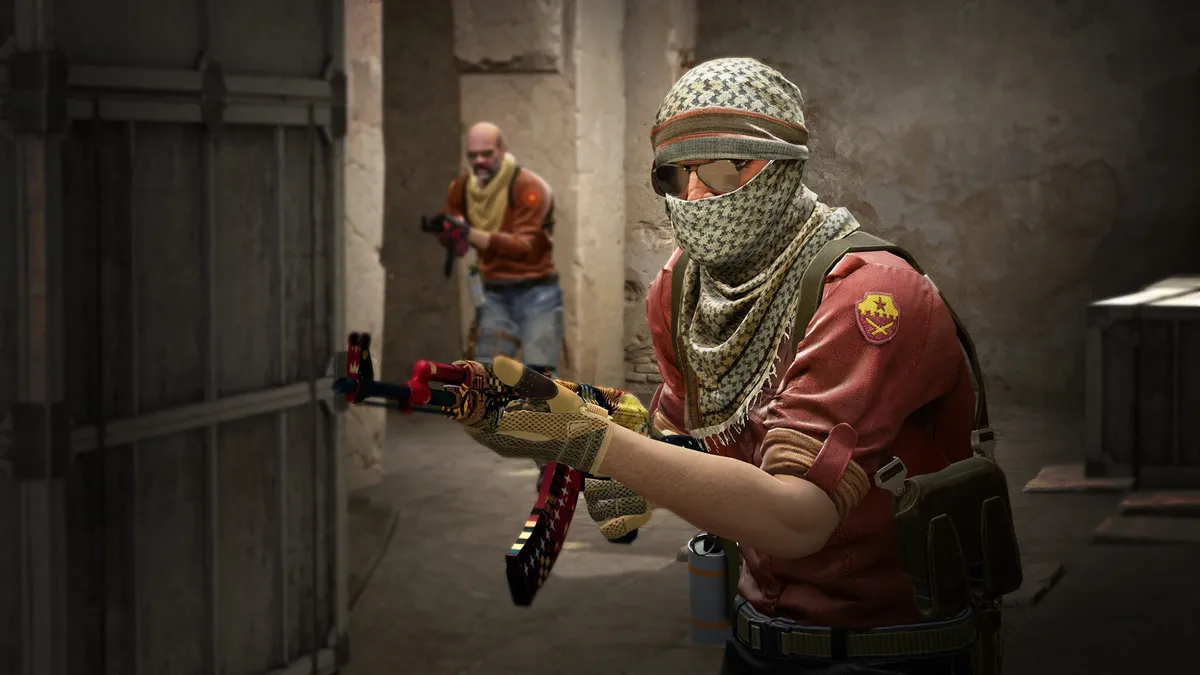

## Introduction to Dataset

ACLED conflict and protest data for African states from 1997 – December 2015 is available in Version 6 of the the ACLED dataset, which was downloaded [here](https://acleddata.com/data-export-tool/). 

The dataset contains the information about conflict event type, actors with allies, interaction codes, time and other variables, which are fully described in [this codebook](https://acleddata.com/acleddatanew/wp-content/uploads/dlm_uploads/2019/01/ACLED_Codebook_2019FINAL.docx.pdf).

## Goal of the Research

In this notebook will use various predictive models to see how accurate they are in predicting number of fatalities during conflicts. Because we are going to predict continuous variable, we will use regression models, such as linear regression with and without regularization, decision tree regressor.

## Research Outline

To accomplish the goal we need to do the following:

I. Data Cleaning - handling missing values

II. Exploratory Data Analysis - visualizing data and taking a look how different features affect the target variable (number of fatalities)

III. Preprocessing - choose necessary features, delete correlated columns, and prepare data for modelling

IV. Predicting - using 5 models and choosing the best one for prediction

V. Conclusions

## Loading Packages and Data

First of all, we need to upload the data and necessary modules for Python. Let's take a look at first 5 rows.

In [1]:
# loading packages
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Loading data
path = '/Users/yumo/Downloads/Traffic_Violation-1/1997-01-01-2021-10-10-Eastern_Africa-Middle_Africa-Northern_Africa-Southern_Africa-Western_Africa.csv'
df = pd.read_csv(path)

print(f'The dataset has {df.shape[0]} observations and {df.shape[1]} features')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/yumo/Downloads/Traffic_Violation-1/1997-01-01-2021-10-10-Eastern_Africa-Middle_Africa-Northern_Africa-Southern_Africa-Western_Africa.csv'

## Research


### Data Cleaning

The first thing we always do with data is exploring how much missing data we have. So, let's do it!

In [2]:
num_rows = len(df)
display(df.isna().sum()*100/num_rows)

data_id              0.000000
iso                  0.000000
event_id_cnty        0.000000
event_id_no_cnty     0.000000
event_date           0.000000
year                 0.000000
time_precision       0.000000
event_type           0.000000
sub_event_type       0.000000
actor1               0.000000
assoc_actor_1       75.293427
inter1               0.000000
actor2              26.693328
assoc_actor_2       81.858424
inter2               0.000000
interaction          0.000000
region               0.000000
country              0.000000
admin1               0.000389
admin2               0.769129
admin3              53.081569
location             0.000000
latitude             0.000000
longitude            0.000000
geo_precision        0.000000
source               0.000000
source_scale         0.000000
notes                3.609738
fatalities           0.000000
timestamp            0.000000
iso3                 0.000000
dtype: float64

Fortunately, we have not so much columns with missing data. Nevertheless, we still need to think how to deal with NaNs. Well, in order to handle missing data, we should figure out why data is missing. We need to ask for a help from the codebook.

* **assoc_actor_1**, **actor2** and **assoc_actor_2**. The named actor associated with or identifying ACTOR1 and ACTOR2.

In most cases, an event requires two actors, noted in columns ‘ACTOR1’ and ‘ACTOR2’. However, event types ‘Explosions/Remote violence’, ‘Riots’, ‘Protests’, and ‘Strategic developments’ can include one-sided events. If more than two actors are reported, only the most important engagement is coded, and the additional groups may be coded as associated actor depending on the context (for example, police forces intervening to disperse rioters). The order of actors has no meaning in the ACLED system, barring cases of ‘Violence against civilians’, in which the victim is always coded as Actor2.

* **admin** (admin1-3) - The sub-national administrative region in which the event took place. **admin1** represents the largest region, **admin3** - the third largest region.

* **notes** - A short description of the event.

Solution:

1. Replace NaNs in **assoc_actor_1** and **assoc_actor_2** as "No associate actor". We consider that data in this columns was missing due to the fact that there was simply no associate actors.

2. Delete rows with NA in **admin1** and **admin2**, as there are very few rows (less than 1% of the data) and this can't really affect the result of predictions. Delete column **admin3** because it shows us too much detail, which may be useless for prediction fatalities.

3. Delete column **notes** because it is text, which mostly includes the information already present in other columns, or too much details.

4. Why **actor2** is missing we are still not sure, so let's postpone it for a while.

In [3]:
# Step 1
df['assoc_actor_1'] = df['assoc_actor_1'].fillna('No associate actor')
df['assoc_actor_2'] = df['assoc_actor_2'].fillna('No associate actor')

# Step 2 and Step 3
df = df.dropna(axis = 0, subset = ['admin1', 'admin2'])
df = df.drop(axis = 1, labels = ['admin3', 'notes'])

print(f'{df.shape[0]} rows and {df.shape[1]} columns has been left.')

255325 rows and 29 columns has been left.


Let's look how much missing data we have in **actor2** after deleting some rows with NA.

In [4]:
num_rows = len(df)
display(df.isna().sum()*100/num_rows)

data_id              0.000000
iso                  0.000000
event_id_cnty        0.000000
event_id_no_cnty     0.000000
event_date           0.000000
year                 0.000000
time_precision       0.000000
event_type           0.000000
sub_event_type       0.000000
actor1               0.000000
assoc_actor_1        0.000000
inter1               0.000000
actor2              26.523059
assoc_actor_2        0.000000
inter2               0.000000
interaction          0.000000
region               0.000000
country              0.000000
admin1               0.000000
admin2               0.000000
location             0.000000
latitude             0.000000
longitude            0.000000
geo_precision        0.000000
source               0.000000
source_scale         0.000000
fatalities           0.000000
timestamp            0.000000
iso3                 0.000000
dtype: float64

There are 26% of observations missed in this column. As we said before, column **actor2** means victims. But...maybe there were no victims? If there were no victims registered, so there are no fatalities. Let's filter the dataset and find out whether our data has missing **actor2**, but has fatalities.

In [5]:
df[['actor1', 'actor2', 'fatalities']][pd.isnull(df['actor2']) & df['fatalities'] !=0]

,actor1,actor2,fatalities
423,Al Shabaab,NaN,15
3263,Islamic State (Libya),NaN,1
5478,Al Shabaab,NaN,1
7383,Military Forces of Nigeria (2015-),NaN,3
7543,JNIM: Group for Support of Islam and Muslims a...,NaN,3
...,...,...,...
184187,Unidentified Armed Group (Somalia),NaN,1
196797,Al Shabaab,NaN,1
201832,AQIM: Al Qaeda in the Islamic Maghreb,NaN,1
208830,Unidentified Armed Group (Madagascar),NaN,1


Interesting, but we have fatalities and no victims registered in 93 rows, which is about 0.1% from the whole missing data in **actor2**. So, although we have victims, we have no information about the group they belong to. Let's fill na here as 'Not Defined'.

In [6]:
df['actor2'] = df['actor2'].fillna('Not Defined')

#Check is there are some NA in dataset
print(f'The dataset has some missing values (true or false)? Answer: {pd.isnull(df).values.any()}')

The dataset has some missing values (true or false)? Answer: False


Fine, let's move to the next step - visualization.

### Exploratory Data Analysis

In this section we are ready to show how different variables influence the number of fatalities. First of all, let's see how the number of fatalities was changing in Africa over the years.

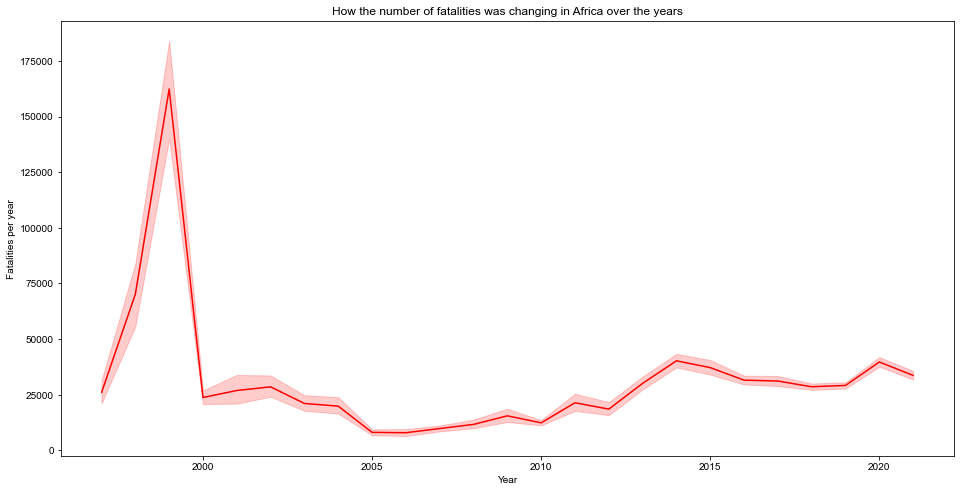

In [7]:
plt.subplots(figsize=(16,8))
sns.set_style("whitegrid")
p = sns.lineplot(x = 'year', y = 'fatalities', data = df, estimator = sum, color = 'red')
p.set(xlabel="Year")
p.set(ylabel="Fatalities per year")
p.set_title("How the number of fatalities was changing in Africa over the years")

plt.show()

We can see a significant peak in the number of fatalities in 1999. By 2005 we may see the decrease in fatal cases, but from this period up to 2021 with some fluctuations the number of fatalities was growing.

It is quite interesting to find what actors were causing the conflicts with the biggest numbers of fatal cases. We are interested how much deaths were associated with particular group on average (not in total).

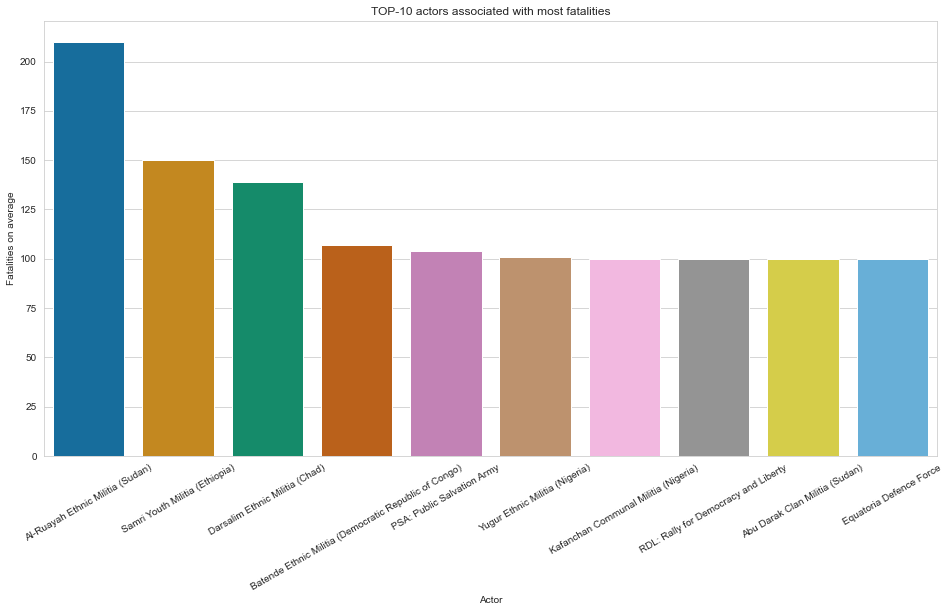

In [8]:
plt.subplots(figsize=(16,8))

df_grouped_by_actors = df.groupby('actor1', as_index = False).agg(mean_fatalities=('fatalities','mean')).sort_values(by = 'mean_fatalities',ascending = False)[:10]

p = sns.barplot(x = 'actor1', y = 'mean_fatalities', data = df_grouped_by_actors, palette = 'colorblind')
p.set(xlabel="Actor")
p.set(ylabel="Fatalities on average")
p.set_title("TOP-10 actors associated with most fatalities")
plt.xticks(rotation=30)
plt.show()

Because we have the data about location, it would be interesting to find countries, where the most fatal conflicts occured.

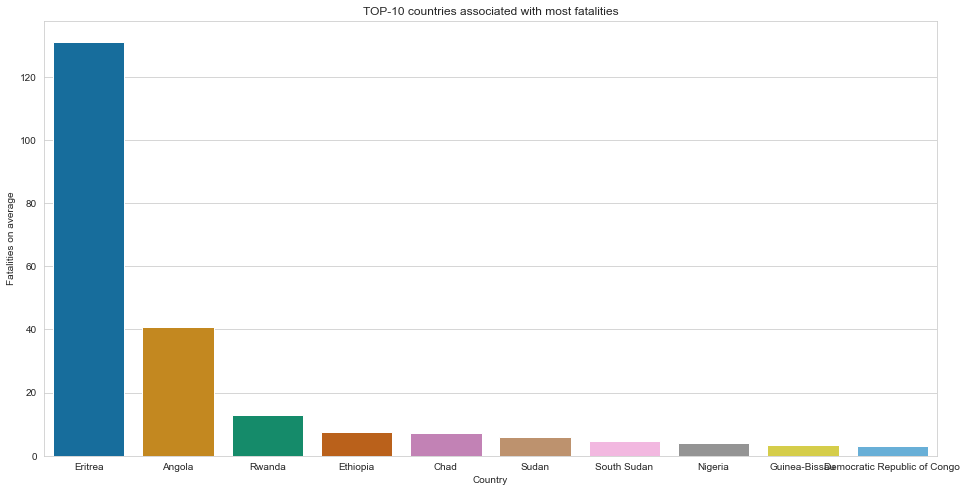

In [9]:
plt.subplots(figsize=(16,8))

df_grouped_by_country = df.groupby('country', as_index = False).agg(mean_fatalities=('fatalities','mean')).sort_values(by = 'mean_fatalities',ascending = False)[:10]

p = sns.barplot(x = 'country', y = 'mean_fatalities', data = df_grouped_by_country, palette = 'colorblind')
p.set(xlabel="Country")
p.set(ylabel="Fatalities on average")
p.set_title("TOP-10 countries associated with most fatalities")
plt.show()

No wonder that Eritrea "won" the TOP. It is considered the most dangerous country to live in, even more than North Korea.

Finally, let's look at the most dangerous subtype of conflict event.

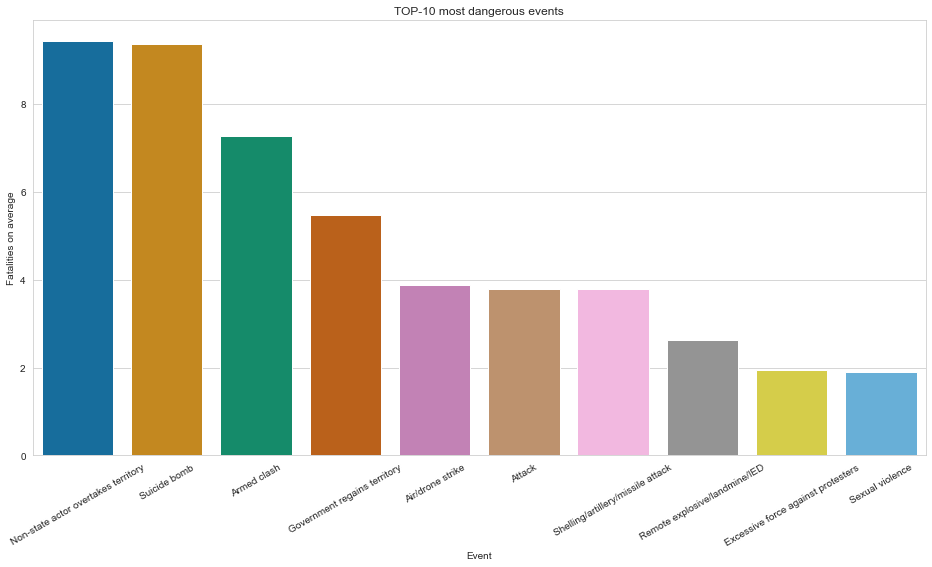

In [10]:
plt.subplots(figsize=(16,8))

df_grouped_by_stevent = df.groupby('sub_event_type', as_index = False).agg(mean_fatalities=('fatalities','mean')).sort_values(by = 'mean_fatalities',ascending = False)[:10]

p = sns.barplot(x = 'sub_event_type', y = 'mean_fatalities', data = df_grouped_by_stevent, palette = 'colorblind')
p.set(xlabel="Event")
p.set(ylabel="Fatalities on average")
p.set_title("TOP-10 most dangerous events")
plt.xticks(rotation=30)
plt.show()

Battles and remote violence are the main source of death in Africa. 

### Preprocessing

To use models, we first need to prepare the data for modelling. First of all, we need to create some features, which may be useful and delete the useless ones. Let's start with deleting. We certainly delete columns with IDs, precision columns, latitude, longitude, source columns and iso columns with dates because they are not needed in prediction.

In [11]:
df1 = df.drop(axis = 1, labels = ['data_id', 'iso', 'event_id_cnty', 'event_id_no_cnty', 'time_precision', 'iso3', 'latitude', 'longitude', 'geo_precision', 'source', 'source_scale', 'data_id', 'timestamp', 'event_date'])

Then, let's see whether we have some correlated columns.

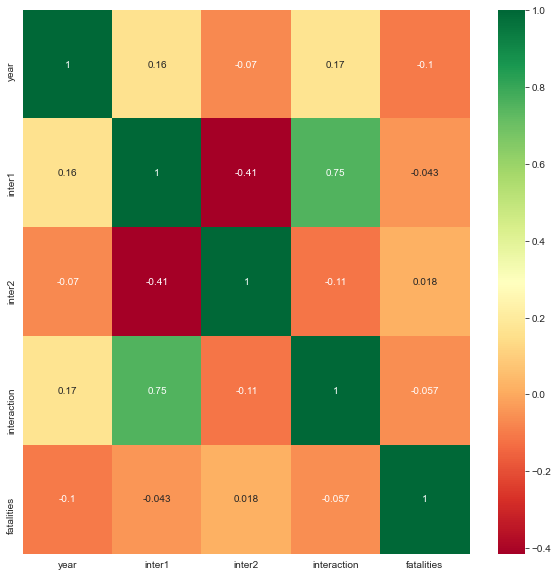

In [12]:
corrmat = df1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))

hm = sns.heatmap(corrmat,
                 cbar=True, annot=True, cmap="RdYlGn")

We don't have it because we, basically, have no predictors that are continuous. The next step is to code categorical variables so that our algorithms could work.

In [13]:
# Coding categorical variables with high cardinality

df1.actor1 = pd.Categorical(df1.actor1)
df1.actor1 = df1.actor1.cat.codes

df1.actor2 = pd.Categorical(df1.actor2)
df1.actor2 = df1.actor2.cat.codes

df1.assoc_actor_1 = pd.Categorical(df1.assoc_actor_1)
df1.assoc_actor_1 = df1.assoc_actor_1.cat.codes

df1.assoc_actor_2 = pd.Categorical(df1.assoc_actor_2)
df1.assoc_actor_2 = df1.assoc_actor_2.cat.codes

df1.admin1 = pd.Categorical(df1.admin1)
df1.admin1 = df1.admin1.cat.codes

df1.admin2 = pd.Categorical(df1.admin2)
df1.admin2 = df1.admin2.cat.codes

df1.location = pd.Categorical(df1.location)
df1.location = df1.location.cat.codes

# Creating dummies from variables with low-medium cardinality

df2 = pd.get_dummies(df1)

df2.head(2)

,year,actor1,assoc_actor_1,inter1,actor2,assoc_actor_2,inter2,interaction,admin1,admin2,...,country_South Africa,country_South Sudan,country_Sudan,country_Tanzania,country_Togo,country_Tunisia,country_Uganda,country_Zambia,country_Zimbabwe,country_eSwatini
0,2021,3997,4343,6,2909,5002,0,60,442,914,...,0,0,0,0,0,1,0,0,0,0
1,2021,3997,4343,6,2909,5002,0,60,582,2290,...,0,0,0,0,0,1,0,0,0,0


OK, we finished with preprocessing. Let's model now!

### Predicting

Before launching the algorithms, we have to divide our dataset to train and test sets (75% train and 25% test accordingly). Also, we apply standartization because we want to be sure that linear models work well.

In [14]:
y = df2['fatalities']
X = df2.drop(columns=['fatalities'])

sc_x = StandardScaler()
X_std = sc_x.fit_transform(X)
X_std = np.array(X_std, dtype=float)
y = y.values
y = np.array(y, dtype=float)

X_train, X_test, y_train, y_test = train_test_split(X_std, y,random_state=3465, test_size = .20)

Now, let's test the algorithms. In our list we include the following:

* Linear Regression
* Lasso
* Ridge
* Logistic Regression
* Decision Tree Regressor

We want to select the best with using R Squared metrics, because it has pretty good interpretability and allows us to show how better models work than the mean.

In [15]:
from sklearn.linear_model import Lasso, Ridge
from statistics import stdev
models = { 
    'Linear Regression' : LinearRegression(n_jobs = -1),
    'Logistic Regression' : LogisticRegression(n_jobs = -1),
    'Decision Tree Regressor' : DecisionTreeRegressor(),
    'Lasso':Lasso(fit_intercept=True),
    'Ridge':Ridge(fit_intercept=True)
}

score_table = pd.DataFrame(columns = ['model', 'r2', 'std'])


for model, n in zip(models, np.arange(len(models))):
                    
    clf = Pipeline([
          ('regression', models[model]),
        ])
    
    clf.fit(X_train, y_train)
    
    cv_3 = cross_val_score(clf, X_test, y_test, cv = 3, scoring = 'r2')
    mean_cv_3 = cv_3.mean()
    std_cv_3 = stdev(cv_3)
    score_table.loc[n,'model'] = model
    score_table.loc[n,'r2'] = mean_cv_3
    score_table.loc[n,'std'] = std_cv_3
    print(f'Model {n} is done')
score_table.sort_values(by = 'r2', ascending = False)

Model 0 is done


/Users/yumo/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


Model 1 is done
Model 2 is done
Model 3 is done
Model 4 is done


,model,r2,std
2,Decision Tree Regressor,0.185231,0.210799
4,Ridge,0.053454,0.015934
3,Lasso,0.046571,0.005019
1,Logistic Regression,-0.148954,0.122056
0,Linear Regression,-358652872544156005695488.0,621204997527003109261312.0


We found out that Decision Tree Regressor works best, although with high standard deviation. Linear and logistic regression work worse than simple mean. Thus, we should pick up optimal parameters for Decision Tree Regressor. We can do that with GridSearch and 3-fold cross validation.

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

regressor = DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           random_state=None, splitter='best') 
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
# расчитываем качество модели линейная регерессия без инетрсепта
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R^2: ', r2_score(y_test, y_pred))


MSE:  618.343320890304
R^2:  0.2868897310867089


In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
# устанавливаем список глубины дерева
params = {'max_depth':[1,2,3,4,5,6,7,8,9,10,20,35]}
# устанавливаем меру качества
scoring_fnc = 'r2'
# устанавливаем как будем переразбивать наш датасет
cv_sets = ShuffleSplit(n_splits = 20, test_size = 0.20, random_state = 0)
# задаем функцию перебора параметров
grid = GridSearchCV(estimator=regressor, 
                    param_grid=params, scoring=scoring_fnc, cv=cv_sets)
# запускаем процедуру поиска
grid = grid.fit(X, y)
# выводим лушие параметры
print(grid.best_params_)
#print(grid.best_score_)

{'max_depth': 8}


In [61]:
print ('\nTrain R2: \n', grid.score(X_train, y_train))
print ('\nTest R2: \n', grid.score(X_test, y_test))


Train R2: 
 -0.22991602353738738

Test R2: 
 -0.2748639278483396


In [18]:
regressor = DecisionTreeRegressor (criterion='mse', max_depth=None, max_features=None,
                                   max_leaf_nodes=None, min_impurity_decrease=0.0,
                                   min_impurity_split=None, min_samples_leaf=1,
                                   min_samples_split=2, min_weight_fraction_leaf=0.0,
                                   random_state=None, splitter='best')
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

In [24]:
from sklearn.model_selection import ShuffleSplit
params = {'max_depth': [1,2,3,4,5,6,7,8,9,10, 20, 35]}
scoring_fnc='r2'
cv_sets = ShuffleSplit(n_splits = 20, test_size = 0.2, random_state = 0)
grid = GridSearchCV(estimator=regressor,
                    param_grid=params, scoring=scoring_fnc, cv=cv_sets)
grid = grid.fit(X_std, y)
print (grid.best_params_)

{'max_depth': 8}


In [26]:
y_pred = grid.best_estimator_.predict (X_std)
print ('MSE: ', mean_squared_error(y, y_pred))
print ('R^2: ', r2_score(y, y_pred))

MSE:  383.94044718922066
R^2:  0.587577244562675


### Conclusions

With a slight overfitting, we got R Squared equals 47% on a test set. Considering a little disbalance in dataset (mainly, 0 deaths), we predicted fatalities much better than using simple mean. The best algorithm was Decision Tree Regressor, while the worst was Linear Regression. Another interesting finding from research were the following:

* The most difficult year for Africa, in terms of fatalities, was 1999 year;

* Most dangerous events type were suicides bombs and battles;

* Eritrea is the most dangerous country in Africa.

All in all, it is difficult to predict the number of fatalities during some conflict, using any model. However, decision tree was working pretty well on this dataset after we picked up best parameters.